In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [37]:
# ==========================================
# Step 1: 环境准备 & 读取数据
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# 设置绘图风格
sns.set_style("whitegrid")

# 读取数据
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# 备份 ID 用于提交，删除训练数据中的 ID
train_ID = train_df['Id']
test_ID = test_df['Id']
train_df.drop("Id", axis=1, inplace=True)
test_df.drop("Id", axis=1, inplace=True)

print(f"✅ 数据读取完成！训练集形状: {train_df.shape}")

✅ 数据读取完成！训练集形状: (1460, 80)


原始偏度 (Skewness): 1.88


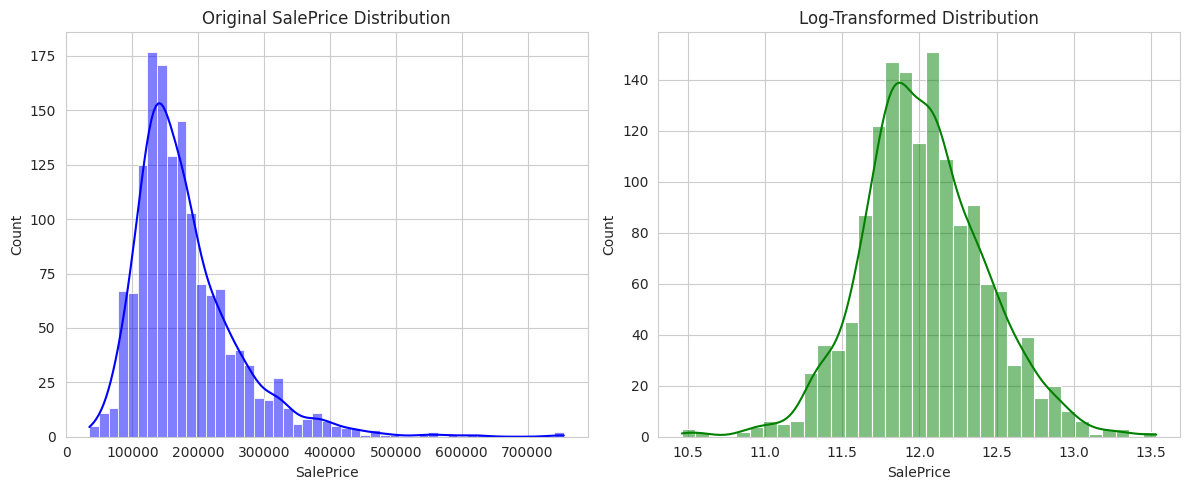

In [38]:
# ==========================================
# Step 2: 目标值分布分析 (Before)
# ==========================================
plt.figure(figsize=(12, 5))

# 画左边的图：原始分布
plt.subplot(1, 2, 1)
sns.histplot(train_df['SalePrice'], kde=True, color='blue')
plt.title('Original SalePrice Distribution')
print(f"原始偏度 (Skewness): {train_df['SalePrice'].skew():.2f}")

# 画右边的图：假如取了对数后的分布 (预演)
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train_df['SalePrice']), kde=True, color='green')
plt.title('Log-Transformed Distribution')

plt.tight_layout()
plt.show()

In [39]:
# ==========================================
# Step 3: 执行 Log 变换
# ==========================================
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
print("✅ 目标值 SalePrice 已完成 Log 平滑处理。")

✅ 目标值 SalePrice 已完成 Log 平滑处理。


/tmp/ipykernel_55/1325159143.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_data_na.index[:20], y=all_data_na.values[:20], palette='viridis')


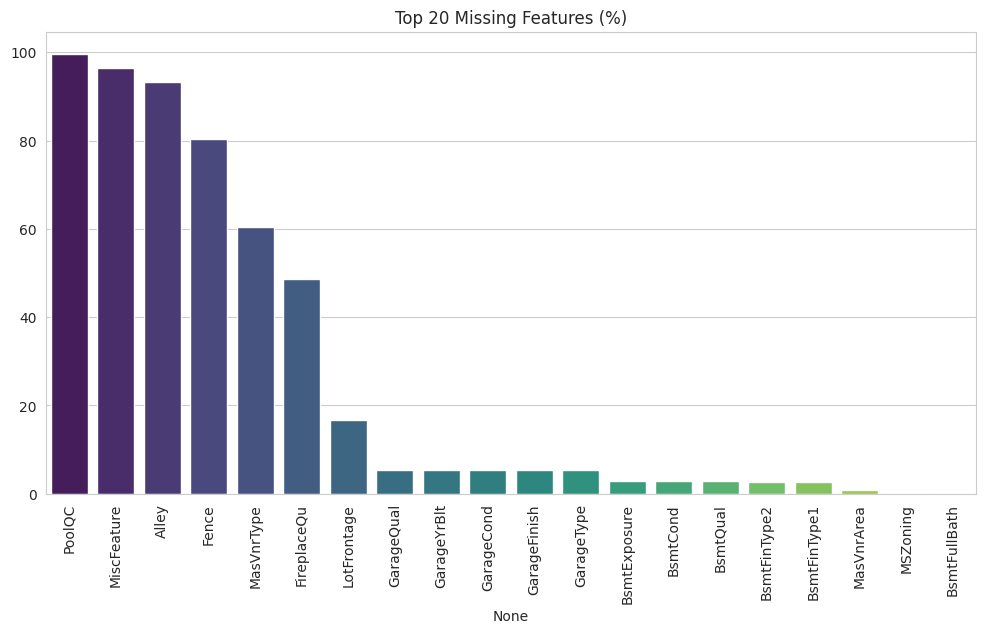

🔍 观察结论：PoolQC, MiscFeature 等缺失率极高，这通常代表'没有该设施'，而非数据丢失。


In [40]:
# ==========================================
# Step 4: 缺失值可视化分析
# ==========================================
# 合并数据以便统一分析
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df.SalePrice.values
all_data = pd.concat((train_df.drop(["SalePrice"], axis=1), test_df)).reset_index(drop=True)

# 计算缺失率
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)

# 画图
plt.figure(figsize=(12, 6))
sns.barplot(x=all_data_na.index[:20], y=all_data_na.values[:20], palette='viridis')
plt.xticks(rotation=90)
plt.title('Top 20 Missing Features (%)')
plt.show()

print("🔍 观察结论：PoolQC, MiscFeature 等缺失率极高，这通常代表'没有该设施'，而非数据丢失。")

In [41]:
# ==========================================
# Step 5: 分层填补缺失值 (Data Imputation)
# ==========================================

# 策略 A: 物理上不存在 (填 "None")
cols_fill_none = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
                  "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                  "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                  "MasVnrType"]
for col in cols_fill_none:
    all_data[col] = all_data[col].fillna("None")

# 策略 B: 数值上不存在 (填 0)
cols_fill_zero = ["GarageYrBlt", "GarageArea", "GarageCars",
                  "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF","TotalBsmtSF",
                  "BsmtFullBath", "BsmtHalfBath", "MasVnrArea"]
for col in cols_fill_zero:
    all_data[col] = all_data[col].fillna(0)

# 策略 C: 邻居填充 (LotFrontage)
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# 策略 D: 众数填充 (遗漏数据)
cols_mode = ["MSZoning", "Electrical", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType", "Functional"]
for col in cols_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

print(f"✅ 数据清洗完成！剩余缺失值: {all_data.isnull().sum().sum()}")

✅ 数据清洗完成！剩余缺失值: 2


In [42]:
# 看看剩下的这 2 个空值到底在哪个列里
missing = all_data.isnull().sum()
print(missing[missing > 0])

Utilities    2
dtype: int64


In [43]:
# === 补丁操作 ===
# Utilities (公用设施) 只有 2 个缺失，且绝大多数都是 "AllPub"
# 把它也填成众数
all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])

# 再检查一次
print(f"最终检查：剩余缺失值: {all_data.isnull().sum().sum()}")

最终检查：剩余缺失值: 0


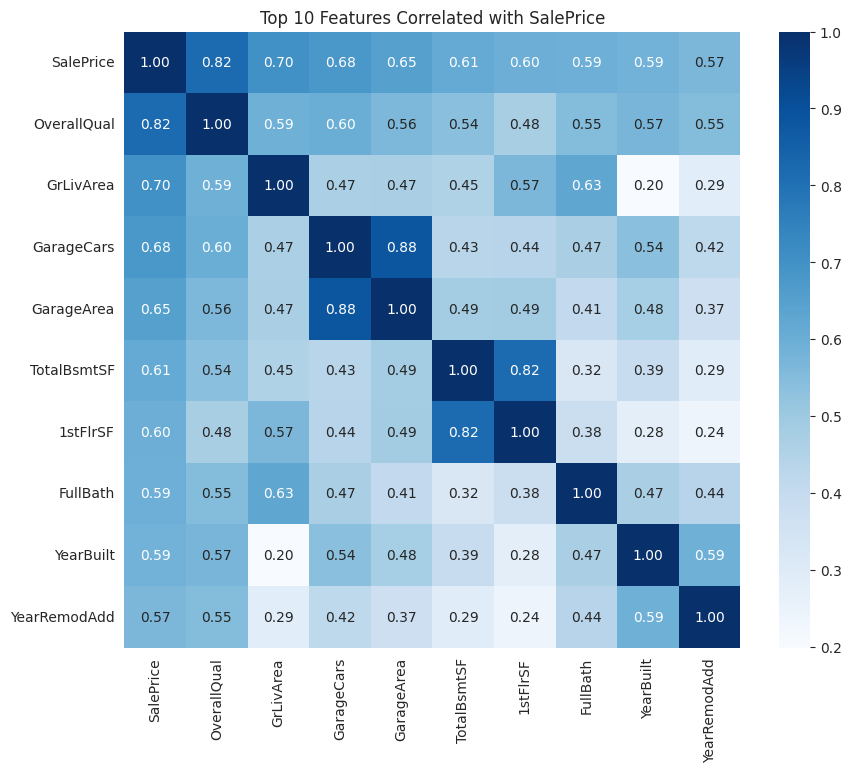

In [44]:
# ==========================================
# Step 6: 相关性分析 (Feature Correlation)
# ==========================================
# 只分析数字型特征
corrmat = train_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
# 选出与房价相关性最强的 10 个特征
k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
            yticklabels=cols.values, xticklabels=cols.values, cmap='Blues')
plt.title('Top 10 Features Correlated with SalePrice')
plt.show()

In [45]:
# ==========================================
# Step 7: 特征编码 (One-Hot Encoding)
# ==========================================
all_data = pd.get_dummies(all_data)
print(f"编码后特征总数: {all_data.shape[1]}")

# 重新拆分回 训练集 和 测试集
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

编码后特征总数: 302


In [46]:
# ==========================================
# Step 8: 模型训练
# ==========================================
model_xgb = xgb.XGBRegressor(
    colsample_bytree=0.46, gamma=0.04, 
    learning_rate=0.05, max_depth=3, 
    min_child_weight=1.5, n_estimators=2200,
    reg_alpha=0.46, reg_lambda=0.85,
    subsample=0.52, random_state=7, n_jobs=-1
)

print("🚀 开始训练 XGBoost...")
model_xgb.fit(X_train, y_train)
print("🎉 训练完成！")

🚀 开始训练 XGBoost...
🎉 训练完成！


In [47]:
# ==========================================
# Step 9: 生成提交文件
# ==========================================
log_predictions = model_xgb.predict(X_test)
final_predictions = np.expm1(log_predictions)

submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = final_predictions
submission.to_csv('submission_eda_xgboost.csv', index=False)

print("✅ submission_eda_xgboost.csv 已生成！")

✅ submission_eda_xgboost.csv 已生成！
